# Intro

Juan Nunez-Iglesias  
Victorian Life Sciences Computation Initiative (VLSCI)  
University of Melbourne  

# Quick example: gene expression, without numpy


|        | Cell type A | Cell type B | Cell type C | Cell type D |
|--------|-------------|-------------|-------------|-------------|
| Gene 0 | 100         | 200         | 50          | 400         |
| Gene 1 | 50          | 0           | 0           | 100         |
| Gene 2 | 350         | 100         | 50          | 200         |

In [1]:
gene0 = [100, 200, 50, 400]
gene1 = [50, 0, 0, 100]
gene2 = [350, 100, 50, 200]
expression_data = [gene0, gene1, gene2]

Why is this a bad idea?

# Now with NumPy

In [2]:
import numpy as np
a = np.array(expression_data)
print(a)

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


We are going to:

* Obtain an *RPKM* expression matrix
* Quantile normalize the data

using the awesome power of NumPy

# Inside a numpy ndarray

In [3]:
def print_info(a):
    print('number of elements:', a.size)
    print('number of dimensions:', a.ndim)
    print('shape:', a.shape)
    print('data type:', a.dtype)
    print('strides:', a.strides)
    print('flags:')
    print(a.flags)
    
print_info(a)

('number of elements:', 12)
('number of dimensions:', 2)
('shape:', (3, 4))
('data type:', dtype('int64'))
('strides:', (32, 8))
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [4]:
print(a.data)

d       �       2       �      2                       d       ^      d       2       �       


In [5]:
abytes = a.ravel().view(dtype=np.uint8)

In [6]:
a.ravel()

array([100, 200,  50, 400,  50,   0,   0, 100, 350, 100,  50, 200])

aravel: all elements of the array in a linear representation (vs. flatten() ? )


In [7]:
print_info(abytes)

('number of elements:', 96)
('number of dimensions:', 1)
('shape:', (96,))
('data type:', dtype('uint8'))
('strides:', (1,))
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [8]:
print(abytes[:24])

[100   0   0   0   0   0   0   0 200   0   0   0   0   0   0   0  50   0
   0   0   0   0   0   0]


### Example: take the transpose of `a`

In [9]:
print_info(a)

('number of elements:', 12)
('number of dimensions:', 2)
('shape:', (3, 4))
('data type:', dtype('int64'))
('strides:', (32, 8))
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [10]:
print_info(a.T)

('number of elements:', 12)
('number of dimensions:', 2)
('shape:', (4, 3))
('data type:', dtype('int64'))
('strides:', (8, 32))
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [11]:
print a.ravel()

[100 200  50 400  50   0   0 100 350 100  50 200]


In [12]:
print a.T.ravel()

[100  50 350 200   0 100  50   0  50 400 100 200]


c-order (default) vs fortran order, either rows are chunked together or columns, differences in performance

processing an array fortran order is way slower in numpy because it operates in c-order?

In [13]:
big_3d_img = np.random.rand(250, 250, 250)

In [14]:
print_info(big_3d_img)

('number of elements:', 15625000)
('number of dimensions:', 3)
('shape:', (250, 250, 250))
('data type:', dtype('float64'))
('strides:', (500000, 2000, 8))
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [15]:
%%timeit
for i in range(big_3d_img.shape[0]):
    big_3d_img[i,:,:] *= 5

# running cell and timing it

100 loops, best of 3: 13.7 ms per loop


In [16]:
%%timeit
for i in range(big_3d_img.shape[2]):
    big_3d_img[:,:,i] *= 5

10 loops, best of 3: 133 ms per loop


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:258: RuntimeWarning: overflow encountered in multiply


### Example: skipping rows and columns with *slicing*

In [17]:
print_info(a.T)

('number of elements:', 12)
('number of dimensions:', 2)
('shape:', (4, 3))
('data type:', dtype('int64'))
('strides:', (8, 32))
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [18]:
print_info(a.T[::2])
# skipping every other row
# neither c nor f contiguous, it has not made a copy
# strides changed to skipping 64 bytes to get to the next row now
# regular slicing does not make a copy
# all patterns that cannot be expressed by strides will

('number of elements:', 6)
('number of dimensions:', 2)
('shape:', (2, 3))
('data type:', dtype('int64'))
('strides:', (16, 32))
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [19]:
print_info(a.T[::2, ::2])

('number of elements:', 4)
('number of dimensions:', 2)
('shape:', (2, 2))
('data type:', dtype('int64'))
('strides:', (16, 64))
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


### Getting a copy

In [20]:
b = a

In [21]:
print(b)

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


In [22]:
a[0, 0] = 5
print(b)
a[0, 0] = 100

[[  5 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


to prevent this: np.copy(a)

# Advanced operations: axis-wise evaluation

In [23]:
expr = np.load('expr.npy')

In [24]:
print_info(expr)

('number of elements:', 7687500)
('number of dimensions:', 2)
('shape:', (20500, 375))
('data type:', dtype('uint32'))
('strides:', (4, 82000))
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


This has the raw read count data. However, each sample gets a different number of reads, so we want to normalize by the *library size*, which is the total number of reads across a column.

The `np.sum` function returns the sum of all the elements of an array. With the `axis` argument, you can take the sum *along the given axis*.

In [25]:
lib_size = np.sum(expr, axis=0)

In [26]:
print expr.shape
print lib_size.shape

(20500, 375)
(375,)


### Exercise

Generate a 10 x 3 array of random numbers. From each row, pick the number closest to 0.75. Make use of np.abs and np.argmax to find the column j which contains the closest element in each row.

In [27]:
randarray = np.random.rand(10, 3)

In [28]:
diffarray = np.abs(randarray - 0.75)

In [29]:
min_indices = np.argmin(diffarray, axis=1)

In [30]:
randarray[np.arange(10), min_indices]

array([ 0.477587  ,  0.76971159,  0.43332058,  0.58341756,  0.78747229,
        0.67871996,  0.84625901,  0.9615591 ,  0.67962043,  0.85353091])

# Advanced operations: broadcasting

In order to normalize every column by its corresponding library size, we have to *align* the two arrays' axes: each dimension must be either the same size, or one of the arrays must have size 1. Use `np.newaxis` to match the dimensions.

In [31]:
print(expr.shape)
print(lib_size.shape)
print(lib_size[np.newaxis, :].shape)

(20500, 375)
(375,)
(1, 375)


However, NumPy will automatically prepend singleton dimensions until the array shapes match or there is an error:

In [32]:
np.all(expr / lib_size ==
       expr / lib_size[np.newaxis, :])

True

In [33]:
expr_lib = expr / lib_size

We also multiply by $10^6$ in order to keep the numbers on a readable scale (reads per million reads).

In [34]:
expr_lib *= 1e6

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  if __name__ == '__main__':


Finally, longer genes are more likely to produce reads. So we normalize by the gene length (in kb) to produce a measure of expression called Reads Per Kilobase per Million reads (RPKM).

In [35]:
gene_len = np.load('gene-lens.npy')
print(gene_len.shape)

(20500,)


In [36]:
print(expr_lib.shape)

(20500, 375)


In [37]:
print gene_len.shape
print gene_len[:, np.newaxis].shape
print np.reshape(gene_len, (gene_len.shape[0], 1)).shape

(20500,)
(20500, 1)
(20500, 1)


### Exercise: broadcast `expr_lib` and `gene_len` together to produce RPKM

In [38]:
rpkm = expr_lib / gene_len[:, np.newaxis] *1e3

In [39]:
rpkm.shape

(20500, 375)

In [42]:
from matplotlib import pyplot as plt
from scipy import stats

def plot_col_density(data, xlim=None, *args, **kwargs):
    # Use gaussian smoothing to estimate the density
    density_per_col = [stats.kde.gaussian_kde(col) for col in data.T]
    if xlim is not None:
        m, M = xlim
    else:
        m, M = np.min(data), np.max(data)
    x = np.linspace(m, M, 100)

    plt.figure()
    for density in density_per_col:
        plt.plot(x, density(x), *args, **kwargs)
    plt.xlabel('log-counts')
    plt.ylabel('frequency')
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()


In [43]:
%matplotlib inline

In [47]:
plt.style.use('ggplot')

AttributeError: 'module' object has no attribute 'style'

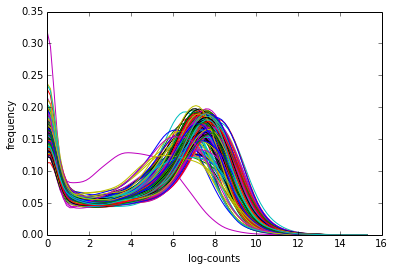

In [48]:
plot_col_density(np.log(expr+1))

In [49]:
plot_col_density(np.log(rpkm + 1), xlim=(0, 250))

LinAlgError: singular matrix

### Exercise: 3D broadcasting

Below, produce the array containing the sum of every element in `x` with every element in `y`

In [56]:
x = np.random.rand(3, 5)
y = np.random.randint(10, size=8)
z = x[:, :, np.newaxis] + y[np.newaxis, np.newaxis, :]
z = x[..., np.newaxis] + y 
# numpy will automatically add the single dimensions if needed
# so long as they are in the front

In [59]:
print x.shape
print y.shape
print x[:, :, np.newaxis].shape
print x[..., np.newaxis].shape
print y[np.newaxis, np.newaxis, :].shape
print z.shape

(3, 5)
(8,)
(3, 5, 1)
(3, 5, 1)
(1, 1, 8)
(3, 5, 8)


### Exercise: explicit broadcasting and stride tricks

Use `np.broadcast_arrays` to get the same-shape arrays that numpy adds together. Then use `print_info` on the output. Notice anything weird?

In [62]:
xx, yy = np.broadcast_arrays(x[..., np.newaxis], y)
# gives you the broadcasted arrays explicitly

In [63]:
print xx.shape
print yy.shape

(3, 5, 8)
(3, 5, 8)


In [68]:
print xx
print yy

[[[ 0.26111774  0.26111774  0.26111774  0.26111774  0.26111774  0.26111774
    0.26111774  0.26111774]
  [ 0.83297296  0.83297296  0.83297296  0.83297296  0.83297296  0.83297296
    0.83297296  0.83297296]
  [ 0.34520162  0.34520162  0.34520162  0.34520162  0.34520162  0.34520162
    0.34520162  0.34520162]
  [ 0.31583239  0.31583239  0.31583239  0.31583239  0.31583239  0.31583239
    0.31583239  0.31583239]
  [ 0.4864744   0.4864744   0.4864744   0.4864744   0.4864744   0.4864744
    0.4864744   0.4864744 ]]

 [[ 0.83535604  0.83535604  0.83535604  0.83535604  0.83535604  0.83535604
    0.83535604  0.83535604]
  [ 0.19950836  0.19950836  0.19950836  0.19950836  0.19950836  0.19950836
    0.19950836  0.19950836]
  [ 0.90545675  0.90545675  0.90545675  0.90545675  0.90545675  0.90545675
    0.90545675  0.90545675]
  [ 0.58111003  0.58111003  0.58111003  0.58111003  0.58111003  0.58111003
    0.58111003  0.58111003]
  [ 0.10605902  0.10605902  0.10605902  0.10605902  0.10605902  0.106059

In [65]:
print_info(yy)

('number of elements:', 120)
('number of dimensions:', 3)
('shape:', (3, 5, 8))
('data type:', dtype('int64'))
('strides:', (0, 0, 8))
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [ ]:
# strides 0 means the next row is the same as the previous!

## Stride tricks

By manipulating the shape and strides of an array, we can produce a "virtual" array much bigger than its memory usage:

In [66]:
def repeat(arr, n):
    return np.lib.stride_tricks.as_strided(arr,
                                           shape=(n,) + arr.shape,
                                           strides=(0,) + arr.strides)

In [67]:
repeat(np.random.rand(5), 4)

array([[ 0.7897398 ,  0.52156511,  0.18879955,  0.01418695,  0.63150516],
       [ 0.7897398 ,  0.52156511,  0.18879955,  0.01418695,  0.63150516],
       [ 0.7897398 ,  0.52156511,  0.18879955,  0.01418695,  0.63150516],
       [ 0.7897398 ,  0.52156511,  0.18879955,  0.01418695,  0.63150516]])

### Exercise: `np.lib.stride_tricks.as_strided`

Use `as_strided` to produce a sliding-window view of a 1D array.

In [73]:
def sliding_window(arr, size=2):
    """Produce an array of sliding window views of `arr`
    
    Parameters
    ----------
    arr : 1D array, shape (N,)
        The input array.
    size : int, optional
        The size of the sliding window.
        
    Returns
    -------
    arr_slide : 2D array, shape (N - size + 1, size)
        The sliding windows of size `size` of `arr`.
        
    Examples
    --------
    >>> a = np.array([0, 1, 2, 3])
    >>> sliding_window(a, 2)
    array([[0, 1],
           [1, 2],
           [2, 3]])
    """
    
    arr = np.lib.stride_tricks.as_strided(arr,
                                         shape=(arr.shape[0] - size + 1, size),
                                         strides=(arr.strides[0], arr.strides[0]))
    
    return arr  # fix this

In [74]:
# test your code here
sliding_window(np.arange(8), 3)

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7]])

# Fancy indexing

You can index arrays with slicing, but also with boolean arrays (including broadcasting!), integer arrays, and individual indices along multiple dimensions.

In [75]:
values = np.array([0, 5, 99])
selector = np.random.randint(0, 3, size=(3, 4))
print(selector)
print(values[selector])

[[1 0 1 0]
 [0 2 2 0]
 [0 0 0 1]]
[[ 5  0  5  0]
 [ 0 99 99  0]
 [ 0  0  0  5]]


### Exercise: quantile normalization

Quantile Normalization(https://en.wikipedia.org/wiki/Quantile_normalization) is a method to align distributions. Implement it using NumPy axis-wise operations and fancy indexing.

*Hint: look for documentation for `scipy.mstats.rankdata`, `np.sort`, and `np.argsort`.*

replace every element by the average quantile by all of the data

In [79]:
def qnorm(x):
    """Quantile normalize an input matrix.
    
    Parameters
    ----------
    x : 2D array of float, shape (M, N)
        The input data, with each column being a
        distribution to normalize.
        
    Returns
    -------
    xn : 2D array of float, shape (M, N)
        The normalized data.
    """
    from scipy.stats.mstats import rankdata
    quantiles = np.mean(np.sort(x, axis=0), axis=1)
    ranks = np.round(rankdata(x, axis=0)).astype(int) -1
    # ranks = np.argsort(np.argsort(x, axis=0))
    
    xn = quantiles[ranks]
    return xn

In [80]:
logexpr = np.log(expr + 1)
logrpkm = np.log(rpkm + 1)

In [81]:
logexprn = qnorm(logexpr)
logrpkmn = qnorm(logrpkm)

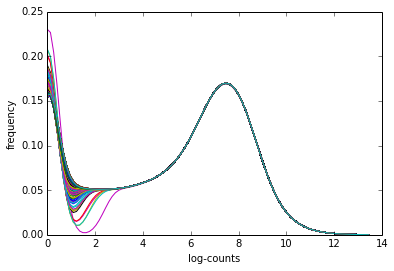

In [82]:
plot_col_density(logexprn)

In [83]:
plot_col_density(logrpkmn, xlim=(0, 0.25))

LinAlgError: singular matrix

## Advanced exercise Jack's dilemma

(If time permits.)

```email
Date: Wed, 16 Jul 2008 16:45:37 -0500
From: Jack Cook
To: <numpy-discussion@scipy.org>
Subject: Numpy Advanced Indexing Question
```

Greetings,

I have an I,J,K 3D volume of amplitude values at regularly sampled
time intervals. I have an I,J 2D slice which contains a time (K)
value at each I, J location. What I would like to do is extract a
subvolume at a constant +/- K window around the slice. Is there an
easy way to do this using advanced indexing or some other method?
Thanks in advanced for your help.

-- Jack

In [ ]:
# "data"

ni, nj, nk = (10, 15, 20)
amplitude = np.random.rand(ni, nj, nk)
horizon = np.random.randint(5, 15, size=(ni, nj))

## Even more advanced: NumPy Array Interface

An author of a foreign package (included with the exercizes as
``problems/mutable_str.py``) provides a string class that
allocates its own memory:

```ipython
In [1]: from mutable_str import MutableString
In [2]: s = MutableString('abcde')
In [3]: print s
abcde
```

You'd like to view these mutable (*mutable* means the ability to modify in place)
strings as ndarrays, in order to manipulate the underlying memory.

Add an __array_interface__ dictionary attribute to s, then convert s to an
ndarray. Numerically add "2" to the array (use the in-place operator ``+=``).

Then print the original string to ensure that its value was modified.

> **Hint:** Documentation for NumPy's ``__array_interface__``
  may be found [in the online docs](http://docs.scipy.org/doc/numpy/reference/arrays.interface.html).

Here's a skeleton outline:

In [ ]:
import numpy as np
from mutable_str import MutableString

s = MutableString('abcde')

# --- EDIT THIS SECTION ---

# Create an array interface to this foreign object
s.__array_interface__ = {'data' : (XXX, False), # (ptr, is read_only?)
                         'shape' : XXX,
                         'typestr' : '|u1', # typecode unsigned character
                         }

# --- EDIT THIS SECTION ---

print 'String before converting to array:', s
sa = np.asarray(s)

print 'String after converting to array:', sa

sa += 2
print 'String after adding "2" to array:', s